In [1]:
from keras import backend as K
from keras.layers import Input, LSTM, RepeatVector, Embedding, TimeDistributed, Dense
from keras.layers import Dropout, BatchNormalization
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
from keras.models import load_model
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
doc_path = 'movieContent.csv'
review_path = 'imdbReview.csv'
MAX_NUM_WORDS = 7000
movie_size = 250

In [3]:
review_header = ['ID', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
doc_file = pd.read_csv(doc_path, encoding='cp950')
review_file = pd.read_csv(review_path, encoding='latin_1', names=review_header)

In [4]:
review_file = review_file.drop(['ID'], axis=1)
review_data = review_file.values

In [7]:
all_comment = [[] for i in range(movie_size)]
for i in range(movie_size):
    for j in range(10):
        all_comment[i].append(review_data[i][j])
all_comment = np.array(all_comment, dtype=str)
all_short_intro = np.array(doc_file['movie_shortIntro'].values, dtype=str)
all_long_intro = np.array(doc_file['movie_longIntro'].values, dtype=str)

In [10]:
def tokenize_doc(doc):
    stopWords = set(stopwords.words('english'))
    ps = nltk.stem.PorterStemmer()
    tokenizer = nltk.tokenize.RegexpTokenizer(r'[a-zA-Z]+')
    sentence = ""
    words = tokenizer.tokenize(doc)
    for w in words:
        temp = str(ps.stem(w.lower()))
#         if temp not in stopWords:
        sentence += temp + " "
    return sentence

In [11]:
train_intro = []
train_comment = []
for i in range(movie_size):
    s_short_intro = tokenize_doc(all_short_intro[i])
    s_long_intro = tokenize_doc(all_long_intro[i])
    train_intro.append(s_short_intro + s_long_intro)
    s_comment = []
    for j in range(10):
        s_comment.append(tokenize_doc(all_comment[i][j]))
    train_comment.append(s_comment)

In [22]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(np.concatenate((train_intro, np.array(train_comment).flatten())))

In [29]:
train_comment = np.array(train_comment)

In [51]:
intro_sequences = tokenizer.texts_to_sequences(train_intro)
intro_matrix = tokenizer.sequences_to_matrix(intro_sequences, mode='count')
intro_matrix /= MAX_NUM_WORDS
comment_matrix = []
for i in range(10):
    temp_sequences = tokenizer.texts_to_sequences(train_comment[:,i])
    temp_matrix = tokenizer.sequences_to_matrix(temp_sequences, mode='count')
    temp_matrix /= MAX_NUM_WORDS
    comment_matrix.append(temp_matrix)
comment_matrix = np.array(comment_matrix)

In [52]:
np.random.seed(5)
indices = np.random.permutation(movie_size)
x_train = (np.average(comment_matrix, axis=0) + intro_matrix) / 2
x_train = x_train[indices]

In [68]:
latent_dim = 30
dnn_encode = [250, 125, latent_dim]
dnn_decode = [250, 500]

In [69]:
inputs = Input(shape=(MAX_NUM_WORDS,))
encoded = Dense(500, activation='relu')(inputs)
encoded = BatchNormalization()(encoded)
encoded = Dropout(0.3)(encoded)
for units in dnn_encode:
    encoded = Dense(units, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
encoder = Model(inputs, encoded)

decoded = Dense(125, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(0.3)(decoded)
for units in dnn_decode:
    decoded = Dense(units, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.3)(decoded)
decoded = Dense(MAX_NUM_WORDS, activation='softmax')(decoded)
autoencoder = Model(inputs, decoded)

In [70]:
callbacks = []
callbacks.append(ModelCheckpoint('model_stopword.h5', monitor='loss', 
                                 save_best_only=True, period=1))
callbacks.append(EarlyStopping(monitor='loss', patience=5))
autoencoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
autoencoder.fit(x_train, x_train, epochs=100, batch_size=5, callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 4s - loss: 0.3096 - acc: 0.0000e+00     
Epoch 2/100
250/250 [==============================] - 1s - loss: 0.2973 - acc: 0.0120     
Epoch 3/100
250/250 [==============================] - 1s - loss: 0.2674 - acc: 0.1720     
Epoch 4/100
250/250 [==============================] - 1s - loss: 0.2413 - acc: 0.4520     
Epoch 5/100
250/250 [==============================] - 1s - loss: 0.2354 - acc: 0.7440     
Epoch 6/100
250/250 [==============================] - 1s - loss: 0.2343 - acc: 0.8120     
Epoch 7/100
250/250 [==============================] - 1s - loss: 0.2342 - acc: 0.7960     
Epoch 8/100
250/250 [==============================] - 1s - loss: 0.2336 - acc: 0.8800     
Epoch 9/100
250/250 [==============================] - 1s - loss: 0.2330 - acc: 0.8840     
Epoch 10/100
250/250 [==============================] - 0s - loss: 0.2332 - acc: 0.9480     
Epoch 11/100
250/250 [==============================] - 1s - loss: 0.2321 -

KeyboardInterrupt: 

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

In [72]:
aut = load_model('model_stopword.h5')
aut.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 7000)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 500)               3500500   
_________________________________________________________________
batch_normalization_29 (Batc (None, 500)               2000      
_________________________________________________________________
dropout_29 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 250)               125250    
_________________________________________________________________
batch_normalization_30 (Batc (None, 250)               1000      
_________________________________________________________________
dropout_30 (Dropout)         (None, 250)               0         
__________

In [73]:
f = K.function([aut.layers[0].input, K.learning_phase()], [aut.layers[10].output])

In [74]:
from sklearn.manifold import TSNE
X = []
for i in range(movie_size):
    temp = f([x_train[i].reshape(1,MAX_NUM_WORDS), 0])[0]
    X.append(temp)
X = np.array(X)

In [75]:
import matplotlib.pyplot as plt
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")           
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X.reshape(movie_size, latent_dim))

Computing t-SNE embedding


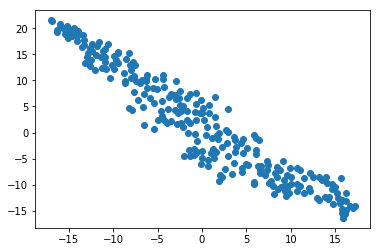

In [76]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

In [83]:
clusters = 20
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(X.reshape(movie_size, latent_dim))

In [84]:
movie_names = np.array(doc_file['movie_name'].values, dtype=str)

In [88]:
movie_classes = [[] for i in range(clusters)]
for i in range(clusters):
    c_movies = np.argwhere(kmeans.labels_==i).flatten()
    for m in c_movies:
        movie_classes[i].append(movie_names[m])

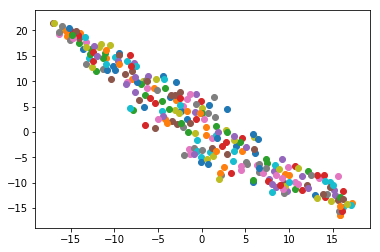

In [89]:
colors = ['#FFB7DD', '#FFBB66', '#FFFF33', '#BBFF00', '#CC0000', '#33CCFF', '#9999FF',
'#00AA55', '#E8CCFF', '#770077', '#FF7744', '#DDDDDD', '#444444']
for i in range(movie_size):
    label = kmeans.labels_[i]
    c = colors[label]
    plt.scatter(X_tsne[i, 0], X_tsne[i, 1], c=c, label=label)
plt.show()

In [81]:
movie_classes[]

['12 Angry Men?',
 'Il buono, il brutto, il cattivo?',
 'Fight Club?',
 'Se7en',
 '?Gladiator',
 'Hotaru no haka?',
 'Oldeuboi',
 'Citizen Kane',
 'North by Northwest',
 'The Treasure of the Sierra Madre',
 'Some Like It Hot',
 'Der Untergang',
 'Die Hard',
 'Chinatown',
 'Lock, Stock and Two Smoking Barrels',
 'A Beautiful Mind?',
 'Gran Torino',
 'T?ky? monogatari',
 'The Deer Hunter',
 'The Thing',
 'There Will Be Blood',
 'Rush?',
 'The Message',
 'The Maltese Falcon',
 'Touch of Evil?',
 'The Grapes of Wrath',
 'Prisoners?',
 'Dog Day Afternoon?',
 'The Imitation Game',
 'Gangs of Wasseypur']